In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import rdkit.Chem as Chem
import sys

sys.path.append('Packages/')

import Mordred.mordred as mordred
from Mordred.mordred import Calculator, descriptors

In [4]:
#Get compounds
compounds = pd.read_csv('Data_set/all_compounds-umbrella.csv')
compounds['mol'] = compounds['IsomericSMILES'].apply(Chem.MolFromSmiles)
compounds.shape

(11985, 17)

In [5]:
def select_columns_equal_values(df):
    threshold = int(0.95 * len(df))  # Calculate the threshold
    selected_columns = []  # Store column names that meet the condition

    for column in df.columns:
        value_counts = df[column].value_counts().iloc[0]  # Count the most frequent value

        if value_counts <= threshold:
            selected_columns.append(column)

    selected_df = df[selected_columns]
    return selected_df

In [6]:
mordred_features = pd.DataFrame()

for module in descriptors.all:
    if module == descriptors.Autocorrelation:
        continue
    
    calc = Calculator(module, ignore_3D=True)

    module_features = calc.pandas(compounds['mol'])
    module_features = module_features.set_index(compounds['CID'])

    object_cols = module_features.dtypes[module_features.dtypes == object].index
    module_features[object_cols] = module_features[object_cols].transform(pd.to_numeric,errors='coerce')
    broken_cols = module_features.columns[module_features.isna().sum() > (0.5 * module_features.shape[0])]
    module_features.drop(columns=broken_cols, inplace=True, errors="ignore")

    module_features = select_columns_equal_values(module_features)

    features_to_keep = []

    while not module_features.empty:
        corr = module_features.corr(method = 'spearman')

        #Count number of features with correlation > 0.7 per row
        corr['count'] = corr.apply(lambda x: x > 0.7, axis=1).sum(axis=1)
        corr.sort_values(by='count', ascending=False, inplace=True)
        corr.drop(columns='count', inplace=True)

        features_to_keep.append(corr.iloc[0].name)
        mordred_features = pd.concat([mordred_features, module_features[corr.iloc[0].name]], axis=1)
        
        #Get column names with correlation > 0.7
        cols_to_drop = corr.columns[corr.iloc[0] > 0.7]

        #Remove cols_to_drop from module_features
        module_features.drop(columns=cols_to_drop, inplace=True)


    print(module)
    print(features_to_keep)
    print(len(features_to_keep))

mordred_features.to_csv('Data_set/mordred_features-within-corr.csv')

 19%|█▉        | 2317/11985 [00:04<00:19, 504.73it/s] 


KeyboardInterrupt: 

In [ ]:
mordred_features

,ABC,SpAbs_A,SpMax_A,SpMAD_A,VE2_A,nAromAtom,nAtom,nHetero,nN,nS,...,Diameter,TopoShapeIndex,Vabc,VAdjMat,MWC01,SRW05,MW,AMW,WPath,mZagreb2
49,5.415816,8.424292,2.135779,1.053037,0.327255,0,16,3,0,0,...,4,1.000000,116.134148,3.807355,7.0,0.000000,116.047344,7.252959,65,1.888889
58,4.530370,7.662988,2.052881,1.094713,0.351405,0,13,3,0,0,...,4,1.000000,98.838163,3.584963,6.0,0.000000,102.031694,7.848592,46,1.777778
70,6.163363,9.335326,2.116883,1.037258,0.308279,0,19,3,0,0,...,5,0.666667,133.430133,4.000000,8.0,0.000000,130.062994,6.845421,96,2.111111
98,4.530370,7.662988,2.052881,1.094713,0.351405,0,11,4,0,1,...,4,1.000000,100.051202,3.584963,6.0,0.000000,119.988115,10.908010,46,1.777778
107,7.996954,13.674401,2.166455,1.243127,0.279464,6,21,2,0,0,...,7,0.750000,147.998485,4.459432,11.0,0.000000,150.068080,7.146099,174,2.583333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
159578871,8.554231,15.006572,2.267318,1.250548,0.266086,0,34,1,0,0,...,7,0.750000,195.246064,4.584963,12.0,0.000000,170.167065,5.004914,204,2.944444
161504856,10.008885,17.982240,2.035158,1.198816,0.219747,0,39,2,0,0,...,13,0.857143,245.711803,4.807355,14.0,0.000000,212.177630,5.440452,530,3.916667
162353069,7.508627,12.054679,2.000000,1.095880,0.289271,0,25,5,0,5,...,8,1.000000,204.877493,4.321928,10.0,0.000000,245.969905,9.838796,204,2.666667
163709488,6.681798,10.568474,2.327022,1.174275,0.309536,0,23,2,0,0,...,5,0.666667,134.852350,4.169925,9.0,2.397895,130.099380,5.656495,85,2.000000


In [ ]:
features_to_keep = []
mordred_features_uncorr = pd.DataFrame()

while not mordred_features.empty:
    corr = mordred_features.corr(method = 'spearman')

    #Count number of features with correlation > 0.7 per row
    corr['count'] = corr.apply(lambda x: x > 0.7, axis=1).sum(axis=1)
    corr.sort_values(by='count', ascending=False, inplace=True)
    corr.drop(columns='count', inplace=True)

    features_to_keep.append(corr.iloc[0].name)
    mordred_features_uncorr = pd.concat([mordred_features_uncorr, mordred_features[corr.iloc[0].name]], axis=1)
    
    #Get column names with correlation > 0.7
    cols_to_drop = corr.columns[corr.iloc[0] > 0.7]

    #Remove cols_to_drop from module_features
    mordred_features.drop(columns=cols_to_drop, inplace=True)

print(mordred_features_uncorr)
mordred_features_uncorr.to_csv('Data_set/mordred_features-uncorrelated.csv')

            SpAbs_DzZ  SM1_Dzse   SpMax_A  nBondsA  NsCH3     VE2_D  \
49          27.716230  0.745484  2.135779        0      2  0.348136   
58          21.530931  0.745484  2.052881        0      1  0.371810   
70          38.096218  0.745484  2.116883        0      2  0.328320   
98          18.638110  0.816841  2.052881        0      0  0.371810   
107         52.370349  0.496990  2.166455        6      0  0.297538   
...               ...       ...       ...      ...    ...       ...   
159578871   69.319291  0.248495  2.267318        0      2  0.283909   
161504856  130.164145  0.496990  2.035158        0      2  0.253948   
162353069   50.868161  0.356781  2.000000        0      0  0.297232   
163709488   34.986828  0.496990  2.327022        0      2  0.328155   
163735825  111.646994  0.745484  2.063403        0      0  0.249688   

              SssCH2        AMW  Xc-4d  VSA_EState3  ...  nARing  n6ARing  \
49          0.000000   7.252959   0.00     8.002870  ...       0      

<AxesSubplot:>

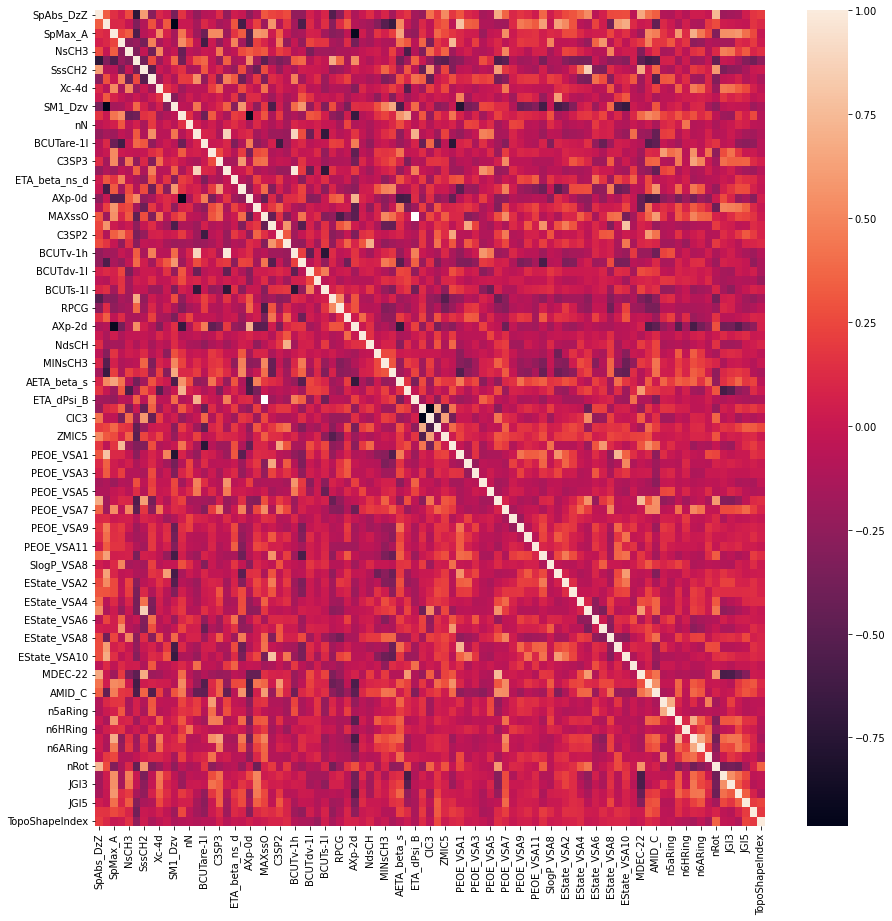

In [ ]:
#Plot correlation matrix
plt.figure(figsize=(15,15))
sns.heatmap(mordred_features_uncorr.corr())


In [ ]:
y = compounds[['alcohol', 'animal', 'aquatic', 'earthy', 'flower','fruity', 'green', 'herbal', 'savory', 'spices', 'woody']] 

#Set all columns in y to dtype category
y = y.astype(int)

y.set_index(compounds['CID'], inplace=True)

y.head

<bound method NDFrame.head of            alcohol  animal  aquatic  earthy  flower  fruity  green  herbal  \
CID                                                                          
49               0       0        0       0       0       1      0       0   
58               0       0        0       0       0       0      0       0   
70               0       0        0       0       0       1      0       0   
98               0       0        0       0       0       0      0       0   
107              0       1        0       0       1       0      0       0   
...            ...     ...      ...     ...     ...     ...    ...     ...   
159578871        0       0        0       0       1       0      0       0   
161504856        0       0        0       0       0       1      1       0   
162353069        0       0        0       0       0       1      1       0   
163709488        0       0        0       0       1       0      1       0   
163735825        0       1        

In [ ]:
from sklearn.impute import SimpleImputer

#Load train data 
train_ids = pd.read_csv('Data_set/data_split/train.csv')
train_ids = train_ids['CID']

X_train = mordred_features_uncorr.loc[train_ids]
y_train = y.loc[train_ids]

imputer = SimpleImputer(strategy='most_frequent')

imputer = SimpleImputer(strategy='most_frequent')

X_imp = pd.DataFrame(imputer.fit_transform(X_train), columns=X_train.columns, index=X_train.index)

#Load test data
test_ids = pd.read_csv('Data_set/data_split/test.csv')
test_ids = test_ids['CID']

X_test = mordred_features_uncorr.loc[test_ids]
y_test = y.loc[test_ids]

X_test_imp = pd.DataFrame(imputer.transform(X_test), columns=X_test.columns, index=X_test.index)

print(X_train.shape)
print(y_train.shape)

print(X_test.shape)
print(y_test.shape)

(5228, 89)
(5228, 11)
(1314, 89)
(1314, 11)


In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.multioutput import MultiOutputClassifier
from sklearn.feature_selection import RFECV
import xgboost as xgb

#Random Forest
clf = xgb.XGBClassifier(random_state=0)
rfe = RFECV(estimator=clf, step=1, cv=5, scoring='accuracy', n_jobs=-1)
rfe.fit(X_imp, y_train)


RFECV(cv=5,
      estimator=XGBClassifier(base_score=None, booster=None, callbacks=None,
                              colsample_bylevel=None, colsample_bynode=None,
                              colsample_bytree=None, early_stopping_rounds=None,
                              enable_categorical=False, eval_metric=None,
                              feature_types=None, gamma=None, gpu_id=None,
                              grow_policy=None, importance_type=None,
                              interaction_constraints=None, learning_rate=None,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=None, max_leaves=None,
                              min_child_weight=None, missing=nan,
                              monotone_constraints=None, n_estimators=100,
                              n_jobs=None, num_parallel_tree=None,
                              predictor=None, random_state=0, ...),
      n_jobs=-1, scoring='accuracy')

In [ ]:
rfe.ranking_

array([ 1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  9,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1, 12,  1,  1,  1,  1,  1,  1,  1,  1,  1, 10,  3,  1,  1,  1,  1,
        7,  1,  1,  1,  5,  1,  1,  1,  1,  1,  1,  4,  2, 11,  8,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  6,  1,
        1,  1,  1,  1])

In [ ]:
from torchmetrics.classification import MultilabelF1Score, MultilabelAUROC, MultilabelPrecision, MultilabelRecall
import torch
from sklearn.metrics import f1_score, roc_auc_score, precision_score, recall_score

for i in range(rfe.ranking_.min(), rfe.ranking_.max()+1):
    print(f"Ranking: {i}")

    columns = X_imp.columns[rfe.ranking_ == i].values

    clf = xgb.XGBClassifier(random_state=0)
    clf.fit(X_imp[columns], y_train)

    y_hat = clf.predict(X_test_imp[columns])

    f1score = MultilabelF1Score(num_labels=11, average="macro", thresholds=None)(torch.tensor(y_hat, dtype=torch.float), torch.tensor(y_test.values, dtype=torch.float))
    auroc_macro = MultilabelAUROC(num_labels=11, average="macro", thresholds=None)(torch.tensor(y_hat, dtype=torch.float), torch.tensor(y_test.values, dtype=torch.long))
    precision_macro = MultilabelPrecision(num_labels=11, average="macro", thresholds=None)(torch.tensor(y_hat, dtype=torch.float), torch.tensor(y_test.values, dtype=torch.long))
    recall_macro = MultilabelRecall(num_labels=11, average="macro", thresholds=None)(torch.tensor(y_hat, dtype=torch.float), torch.tensor(y_test.values, dtype=torch.long))

    f1_score_sk = f1_score(y_test, y_hat, average="macro")

    print(f"F1 Score: {f1score}")
    print(f"F1 Score (sklearn): {f1_score_sk}")
    print(f"AUROC: {auroc_macro}")
    print(f"Precision: {precision_macro}")
    print(f"Recall: {recall_macro}")
    print("=====================================")

Ranking: 1
F1 Score: 0.5068886280059814
F1 Score (sklearn): 0.5068885798716921
AUROC: 0.6839672923088074
Precision: 0.6030007600784302
Recall: 0.4485816955566406
Ranking: 2
F1 Score: 0.11406964808702469
F1 Score (sklearn): 0.11406965128504375
AUROC: 0.5228434801101685
Precision: 0.3105756938457489
Recall: 0.07906070351600647
Ranking: 3
F1 Score: 0.2061731517314911
F1 Score (sklearn): 0.20617314573998266
AUROC: 0.5416831374168396
Precision: 0.3723997175693512
Recall: 0.16097116470336914
Ranking: 4
F1 Score: 0.12698017060756683
F1 Score (sklearn): 0.12698017482499113
AUROC: 0.5283119678497314
Precision: 0.4384012222290039
Recall: 0.08878421783447266
Ranking: 5
F1 Score: 0.14092572033405304
F1 Score (sklearn): 0.14092571344381674
AUROC: 0.5304158329963684
Precision: 0.4620835781097412
Recall: 0.09835546463727951
Ranking: 6
F1 Score: 0.1527417004108429
F1 Score (sklearn): 0.15274169755832834
AUROC: 0.5248019695281982
Precision: 0.314929336309433
Recall: 0.11992265284061432
Ranking: 7
F1 Sc

In [ ]:
X_selected = X_imp[X_imp.columns[rfe.ranking_ == 1]]
print(X_selected.shape)

clf = xgb.XGBClassifier(random_state=0)
clf.fit(X_selected, y_train)

y_hat = clf.predict(X_test_imp[X_selected.columns])

f1score = MultilabelF1Score(num_labels=11, average="macro", thresholds=None)(torch.tensor(y_hat, dtype=torch.float), torch.tensor(y_test.values, dtype=torch.float))

auroc_macro = MultilabelAUROC(num_labels=11, average="macro", thresholds=None)(torch.tensor(y_hat, dtype=torch.float), torch.tensor(y_test.values, dtype=torch.long))

print(f"F1 Score: {f1score}")
print(f"AUROC: {auroc_macro}")

(5228, 78)
F1 Score: 0.5068886280059814
AUROC: 0.6839672923088074


In [ ]:
#Save newly selected features
selected_features = X_selected.columns
selected_features_all = mordred_features_uncorr[selected_features]

# imp = SimpleImputer(strategy='most_frequent')
# selected_features_all = pd.DataFrame(imp.fit_transform(selected_features_all), columns=selected_features_all.columns, index=selected_features_all.index)

selected_features_all.reset_index(inplace=True)

#Rename first column to CID
selected_features_all.rename(columns={'index': 'CID'}, inplace=True)

selected_features_all.to_csv('Data_set/mordred_features-final_selection.csv', index=False)

from sklearn.preprocessing import SimpleImputer

imp = SimpleImputer(strategy='most_frequent')
selected_features_all = pd.DataFrame(imp.fit_transform(selected_features_all), columns=selected_features_all.columns, index=selected_features_all.index)
selected_features_all.to_csv('Data_set/mordred_features-final_selection-imputed.csv', index=False)  


C:\Users\Stijn\AppData\Local\Temp\ipykernel_10140\3212592812.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_features_all.rename(columns={'index': 'CID'}, inplace=True)
